# COMP90051 Workshop 4
## Logistic regression
***
In this workshop we'll be implementing L2-regularised logistic regression using `scipy` and `numpy`. 
Our key objectives are:

* to become familiar with the optimisation problem that sits behind L2-regularised logistic regression;
* to apply polynomial basis expansion and recognise when it's useful; and
* to experiment with the effect of L2 regularisation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

### 1. Binary classification data
Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

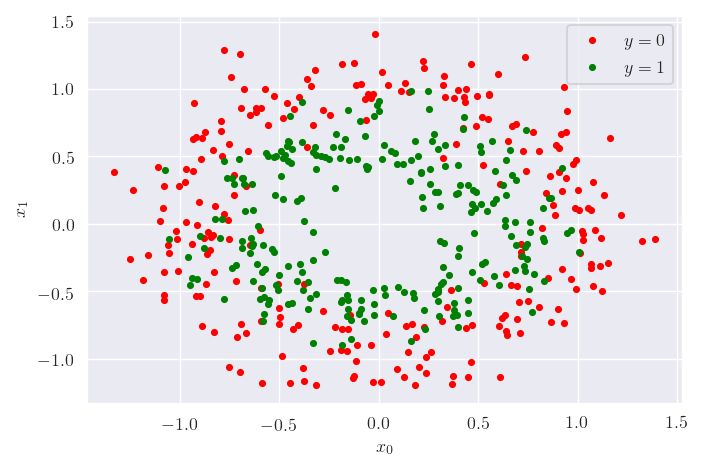

In [4]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=500, noise=0.17, factor=0.65, random_state=90051)
plt.plot(X[Y==0,0], X[Y==0,1], '.', label = "$y=0$", c='r')
plt.plot(X[Y==1,0], X[Y==1,1], '.', label = "$y=1$", c='g')
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

**Question:** What's interesting about this data? Do you think logistic regression will perform well?

**Answer:** *This question is answered in section 3.*

In preparation for fitting and evaluating a logistic regression model, we randomly partition the data into train/test sets. We use the `train_test_split` function from `sklearn`.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 400 instances. Test set has 100 instances.


## 2. Logistic Regression
In binary classification we receive training data $\mathcal{D} = \left((\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\right)$, where $\mathbf{x}_k \in \mathbb{R}^N$ denotes the feature vector associated with the $k$th training point and the targets $y \in \{0,1\}$. Logistic regression models the distribution of the binary target $y$ *conditional* on the feature vector $\mathbf{x}$ as

\begin{equation}
y | \mathbf{x} \sim \mathrm{Bernoulli}[\sigma(\mathbf{w}^T \mathbf{x} + b)]
\end{equation}

where $\mathbf{w} \in \mathbb{R}^N$ is the weight vector, $b \in \mathbb{R}$ is the bias term and $\sigma(z) = 1/(1 + e^{-z})$ is the logistic function. Note here our parameter of interest $\theta$ is the conditional probability of a particular instance belonging to class 1 given observation of the associated feature vector $\mathbf{x}$:

$$\theta = p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x} + b\right) $$
To simplify the notation, we'll collect the model parameters $\mathbf{w}$ and $b$ in a single vector $\mathbf{v} = [b, \mathbf{w}]$. 

To find appropriate parameters $\mathbf{v}$, we want to maximize the log-likelihood with respect to $\mathbf{v}$, in lecture it was shown this is equivalent to minimization of the sum of cross-entropies over the instances ($i = 1,\ldots,n$) in the training set


$$
\mathcal{L}_{CE}(\mathbf{v}; \mathbf{x}, \mathbf{y}) = -\log \prod_{i=1}^n p\left(y_i \vert \mathbf{x}_i\right) = - \sum_{i = 1}^{n} \left\{ y_i \log p(y=1 \vert \mathbf{x}) + (1 - y_i) \log p (y=0 \vert \mathbf{x}) \right\}
$$

Often an L2 regularisation term of the form $\mathcal{L}_{\mathrm{reg}}(\mathbf{w}) = \frac{1}{2} \lambda \mathbf{w}^T \mathbf{w}$ is added to the objective to penalize large weights (this can help prevent overfitting to idiosycrancies in the training set). Note that $\lambda \geq 0$ controls the strength of the regularisation term.

Putting this together, our goal is to minimise the following objective function with respect to $\mathbf{v}$:
$$
\mathcal{L}(\mathbf{v}; \mathbf{x}, \mathbf{y}) = \mathcal{L}_\mathrm{reg}(\mathbf{w}) + \mathcal{L}_{CE}(\mathbf{v}; \mathbf{x}, \mathbf{y})
$$

***
#### **Exercise 1 (Discussion?):** 
The L2 regularization term  $\mathcal{L}_{\mathrm{reg}}(\mathbf{w}) = \frac{1}{2} \lambda \mathbf{w}^T \mathbf{w}$ is commonly said to reduce overfitting. Give a brief justification why?

#### **Exercise 2 (Discussion?):** 
Why do we only include the weights $\mathbf{w}$ in the L2 regularization term? i.e. the bias terms are excluded from regularization.

#### **Exercise 3:**
Given we model the conditional probability of label $y=1$ to be $p(y = 1 \vert \mathbf{x}) = \sigma\left(\mathbf{w}^T \mathbf{x} + b\right)$, show that prediction is based on a linear decision rule given by the sign of logarithm of the ratio of probabilities:

\begin{equation}
    \log \frac{p(y=1 \vert \mathbf{x})}{p(y=0 \vert \mathbf{x})} = \mathbf{w}^T \mathbf{x} + b
\end{equation}

This is why logistic regression is referred to as a _log-linear model_. What is the decision boundary for logistic regression? 
***

We're going to find a solution to this minimisation problem using the BFGS algorithm (named after the inventors Broyden, Fletcher, Goldfarb and Shanno). BFGS is a "hill-climbing" algorithm like gradient descent, however it additionally makes use of second-order derivative information (by approximating the Hessian). It converges in fewer iterations than gradient descent (it's convergence rate is *superlinear* whereas gradient descent is only *linear*).

We'll use an implementation of BFGS provided in `scipy` called `fmin_bfgs`. The algorithm requires two functions as input: (i) a function that evaluates the objective $f(\mathbf{v}; \ldots)$ and (ii) a function that evalutes the gradient $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

Let's start by writing a function to compute $f(\mathbf{v}; \ldots)$.

In [4]:
from scipy.special import expit # this is the logistic function
sigmoid = expit

# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def objective(v, X, Y, Lambda, L2=True):
    #  Implement the logistic regression objective here
    """
    Inputs:
    v:            Parameter vector, shape [n+1]
                  Should contain bias term as zeroth element
    X:            Feature matrix, shape [N, n]
    Y:            Labels, shape [N]
    
    Outputs:
    loss:         (Scalar) objective value
    """
    epsilon = 1e-5  # numerical stability
    prob_1 = sigmoid(np.dot(X,v[1::]) + v[0])  # fill in
    L2_loss = 0.5 * Lambda * np.dot(v[1::],v[1::]) # fill in
    cross_entropy = - np.dot(Y, np.log(prob_1 + epsilon)) - np.dot(1. - Y, np.log(1. - prob_1 + epsilon))  # fill in
    
    if L2 is True:
        loss = cross_entropy + L2_loss
    else:
        loss = cross_entropy
        
    return loss

Now for the gradient, we use the following result (if you're familiar with vector calculus, you may wish to derive this yourself):
$$
\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots) = \left[\frac{\partial f(\mathbf{w}, b;\ldots)}{\partial b}, \nabla_{\mathbf{w}} f(\mathbf{w}, b; \ldots) \right] = \left[\sum_{i = 1}^{n} \sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i, \lambda \mathbf{w} + \sum_{i = 1}^{n} (\sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i)\mathbf{x}_i\right]
$$

The function below implements $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

In [5]:
# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def grad_objective(v, X, Y, Lambda):
    prob_1 = sigmoid(np.dot(X, v[1::]) + v[0])
    grad_b = np.sum(prob_1 - Y)
    grad_w = Lambda * v[1::] + np.dot(prob_1 - Y, X)
    return np.insert(grad_w, 0, grad_b)

Here we'll write a function to compute the solution through vanilla gradient descent. Recall that we follow the negative of the gradient in parameter space to update our parameters. Recall the basic update loop is as follows:

$$ \bf{w}_{t+1} = \bf{w}_t - \eta_t \nabla_w \mathcal{L}(\bf{w}) $$

Note that this simple procedure is the workhorse of many non-convex optimization programs, such as those used in modern neural network libraries. Contemporary libraries add more spice to the exact update, but the core idea of traversing some loss landscape in the direction of the negative gradient remains the same.

Typically we halt when some stopping condition is reached, in this case we'll stop when the 2-norm of the difference between iterates drops below some threshold $\epsilon$.

$$ \Vert \bf{w}_{t+1} - \bf{w}_t \Vert^2 \leq \epsilon $$

You could also use other stopping criteria, such as if the difference between two consecutive loss values drops below some threshold.

In [26]:
def logistic_regression_gd(X, Y, Lambda, v_initial, eta=0.01, iterations=42, L2=True, EPS=1e-5):
    """
    X: feature matrix
    Y: class labels
    Lambda: regularisation constant
    v_initial: initial guess for parameter vector
    eta: Learning rate
    iterations: Number of GD iterations
    """
    if L2 is False:
        Lambda = 0.0
    
    v_history = [v_initial]
    grad_history = [grad_objective(v_initial, X, Y, Lambda)]
    v = v_initial

    for itr in range(iterations):
        
        grad_v = grad_objective(v, X, Y, Lambda)
        v = v - eta * grad_v
        
        # Stopping condition
        if np.linalg.norm(v-v_history[-1]) < EPS:
            print('Ok, past iterates are pretty similar, I can stop now!')
            break
            
        print('v:', v, ' | Objective: {:.3f}'.format(objective(v, X, Y, Lambda)), '| Gradient 2-norm: {:.3f}'.format(np.linalg.norm(grad_v)))    
        v_history.append(v)
        grad_history.append(grad_v)
        
    return v, v_history, grad_history

Let's try it out! We'll guess an initial parameter vector of $v_0 = (3,1,4)$.

**Exercise:** Investigate how different initializations of $v_0$ and learning rates $\eta$ change the convergence of the algorithm, by reference to the contour plot below. If you are familiar with optimization theory, you may know that convergence of GD on is only guaranteed for an appropriately decaying learning rate $\eta_t$. You may want to decay $\eta_t$ with time, e.g. $\eta_t = C/(t+1), C/(t+1)^2$, etc. for some constant $C$.

In [27]:
Lambda = 1
v_opt, v_history, grad_history = logistic_regression_gd(X_train, Y_train, Lambda, v_initial=(3,1,4), eta=0.01)
w = v_opt

v: [1.66881284 0.79151154 3.46541716]  | Objective: 554.533 | Gradient 2-norm: 144.959
v: [0.79269244 0.55985801 2.75360246]  | Objective: 435.146 | Gradient 2-norm: 115.236
v: [0.26927322 0.34969664 2.01477918]  | Objective: 358.635 | Gradient 2-norm: 92.951
v: [0.0193582  0.18521991 1.36394222]  | Objective: 314.485 | Gradient 2-norm: 71.631
v: [-0.05792576  0.07098853  0.86845399]  | Objective: 292.327 | Gradient 2-norm: 51.433
v: [-0.07081158 -0.00210317  0.53232336]  | Objective: 282.641 | Gradient 2-norm: 34.423
v: [-0.07300768 -0.04680464  0.32013991]  | Objective: 278.854 | Gradient 2-norm: 21.685
v: [-0.07455071 -0.07355921  0.19088828]  | Objective: 277.459 | Gradient 2-norm: 13.200
v: [-0.07577645 -0.08945082  0.11327772]  | Objective: 276.958 | Gradient 2-norm: 7.923
v: [-0.07663006 -0.09887802  0.06691379]  | Objective: 276.779 | Gradient 2-norm: 4.732
v: [-0.07718453 -0.10447384  0.03926298]  | Objective: 276.715 | Gradient 2-norm: 2.822
v: [-0.07753168 -0.1077983   0.022

Notice that the magnitude of the gradient decays as we approach the optimum. This is expected, $\nabla f$ is the direction of the steepest rate of change, so $\Vert \nabla f \Vert$ is the maximum rate of change, which should decrease as we approach the optimum of an approximately convex function. To visualize the loss landscape, we'll plot a contour plot of the loss function as well as some intermediate solutions for the weights $w_1$, $w_2$. This allows us to examine how the objective changes as a function of the weights. Note that we exclude the bias term otherwise this would not be possible to visualize!

Text(0.5,1,'Contour plot of objective function in weight space - GD')

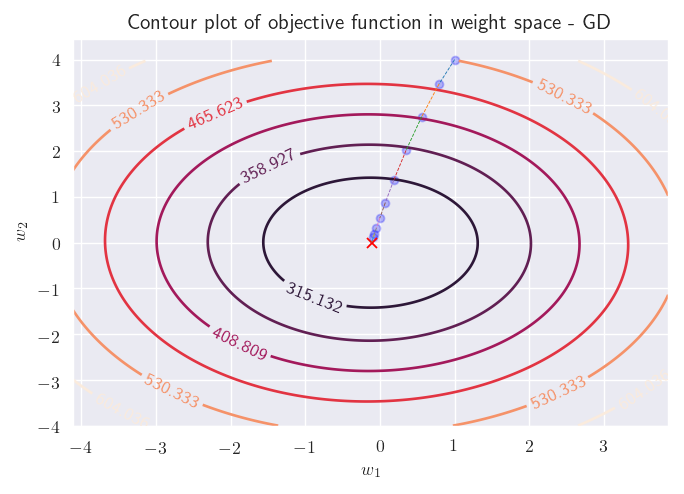

In [28]:
delta = 0.025
eta = 0.4
w1_limit = 4
w2_limit = 4
w1, w2 = np.meshgrid(np.arange(w[1]-w1_limit, w[1]+w1_limit, delta), np.arange(w[2]-w2_limit, w[2]+w2_limit, delta))
ws = np.vstack([w[0] * np.ones_like(w1.flatten()), w1.flatten(), w2.flatten()])
obj = np.zeros(ws.shape[1])
for i in range(ws.shape[1]):
    obj[i] = objective(ws[:,i], X_train, Y_train, Lambda=1.0)
    
plt.figure()
CS = plt.contour(w1, w2, obj.reshape(w1.shape), levels=np.exp(np.linspace(np.log(min(obj.flatten())), np.log(max(obj.flatten())), 8)))

# Plot minimum returned by GD
plt.plot(w[1], w[2], 'rx')
norm = lambda x: x/np.sqrt(np.sum(np.square(x)))
# Plot sequence of parameter vectors calculated via GD
for grad_v, v in zip(grad_history[:10], v_history[:10]):
    plt.scatter(v[1], v[2], s=20, c='b', alpha=0.25)
    
for i in range(len(v_history)-1):
    plt.plot([v_history[i][1], v_history[i+1][1]], [v_history[i][2], v_history[i+1][2]], lw=0.5, ls='--')
    
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.title('Contour plot of objective function in weight space - GD')

### 3. Solving the minimization problem using BFGS

Gradient descent only uses first order derivative information to update parameters (it extrapolates from the current parameter value using a linear approximation to the function). Second-order methods such as BFGS can use the second-order derivative information to increase the rate of convergence. BFGS constructs an approximation to the Hessian matrix of second derivatives at each iteration, and uses this information to guide the next update. However such methods leveraging Hessian information tend to require a high space complexity and are only used for problems with a relatively low number of parameters.

Now that we've implemented functions to compute the objective and the gradient, we can plug them into `fmin_bfgs`.
Specifically, we define a function `my_logistic_regression` which calls `fmin_bfgs` and returns the optimal weight vector.

In [9]:
from scipy.optimize import fmin_bfgs

# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
# v_initial: initial guess for parameter vector
def logistic_regression_bfgs(X, Y, Lambda, v_initial, disp=True, L2=True):
    
    if L2 is False:
        Lambda = 0.0
    
    v_history = [v_initial]
    grad_history = [grad_objective(v_initial, X, Y, Lambda)]
    
    def display(v):
        # Function for displaying progress
        grad = grad_objective(v, X, Y, Lambda)
        print('v:', v, ' | Objective: {:.3f}'.format(objective(v, X, Y, Lambda)), '| Gradient 2-norm: {:.3f}'.format(np.linalg.norm(grad)))
        v_history.append(v)
        grad_history.append(grad)
    
    return fmin_bfgs(f=objective, fprime=grad_objective, 
                     x0=v_initial, args=(X, Y, Lambda), disp=disp, 
                     callback=display), v_history, grad_history

Let's try it out!

In [10]:
Lambda = 1
v_initial = np.zeros(X_train.shape[1] + 1) # fill in a vector of zeros of appropriate length
# Hint: how many parameters in our model?
v_opt, v_history, grad_history = logistic_regression_bfgs(X_train, Y_train, Lambda, v_initial=(3,1,4))
w = v_opt

v: [2.07249578 0.85473573 3.62752958]  | Objective: 605.597 | Gradient 2-norm: 124.624
v: [1.02528459 0.19863845 1.35913656]  | Objective: 364.189 | Gradient 2-norm: 98.378
v: [0.46557321 1.0757881  0.37597413]  | Objective: 320.924 | Gradient 2-norm: 67.378
v: [-0.11376665 -0.1147479  -0.16076419]  | Objective: 277.245 | Gradient 2-norm: 7.143
v: [-0.08875152 -0.12077606  0.06887194]  | Objective: 276.789 | Gradient 2-norm: 3.114
v: [-0.07143037 -0.11378324 -0.00315145]  | Objective: 276.683 | Gradient 2-norm: 0.668
v: [-0.07976015 -0.11171169 -0.00249982]  | Objective: 276.680 | Gradient 2-norm: 0.173
v: [-0.07807197 -0.11276522 -0.0014831 ]  | Objective: 276.680 | Gradient 2-norm: 0.004
v: [-0.07806451 -0.11266613 -0.00153879]  | Objective: 276.680 | Gradient 2-norm: 0.001
v: [-0.07806743 -0.11267766 -0.00153817]  | Objective: 276.680 | Gradient 2-norm: 0.000
         Current function value: 276.680322
         Iterations: 10
         Function evaluations: 82
         Gradient evalu

We'll plot a contour plot of the loss function as well as some intermediate solutions for the weights $w_1$, $w_2$. You should observe that this exhibits much faster convergence than vanilla GD. Unfortunately, due to the added complexity of the algorithm, approximate second order methods such as BFGS are only viable for problems with a relatively small number of parameters.

Text(0.5,1,'Contour plot of objective function in weight space - BFGS')

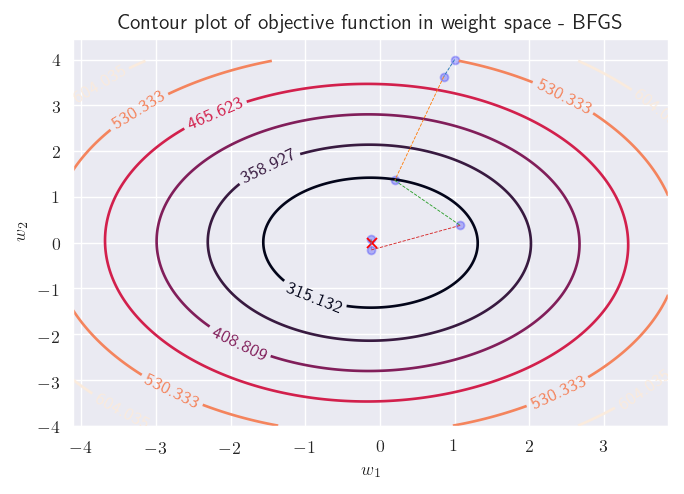

In [11]:
delta = 0.025
eta = 0.4
w1_limit = 4
w2_limit = 4
w1, w2 = np.meshgrid(np.arange(w[1]-w1_limit, w[1]+w1_limit, delta), np.arange(w[2]-w2_limit, w[2]+w2_limit, delta))
ws = np.vstack([w[0] * np.ones_like(w1.flatten()), w1.flatten(), w2.flatten()])
obj = np.zeros(ws.shape[1])
for i in range(ws.shape[1]):
    obj[i] = objective(ws[:,i], X_train, Y_train, Lambda=1.0)
    
plt.figure()
CS = plt.contour(w1, w2, obj.reshape(w1.shape), levels=np.exp(np.linspace(np.log(min(obj.flatten())), np.log(max(obj.flatten())), 8)))

# Plot minimum returned by BFGS
plt.plot(w[1], w[2], 'rx')
norm = lambda x: x/np.sqrt(np.sum(np.square(x)))
# Plot sequence of parameter vectors calculated via BFGS
for grad_v, v in zip(grad_history[:6], v_history[:6]):
    plt.scatter(v[1], v[2], s=20, c='b', alpha=0.25)
#     w1_grad, w2_grad = grad_v[1], grad_v[2]
#     w1_grad, w2_grad = norm(w1_grad), norm(w2_grad)
    # plt.plot([v[1], v[1] - eta * w1_grad], [v[2], v[2] - eta * w2_grad])
for i in range(len(v_history)-1):
    plt.plot([v_history[i][1], v_history[i+1][1]], [v_history[i][2], v_history[i+1][2]], lw=0.5, ls='--')
    
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.title('Contour plot of objective function in weight space - BFGS')

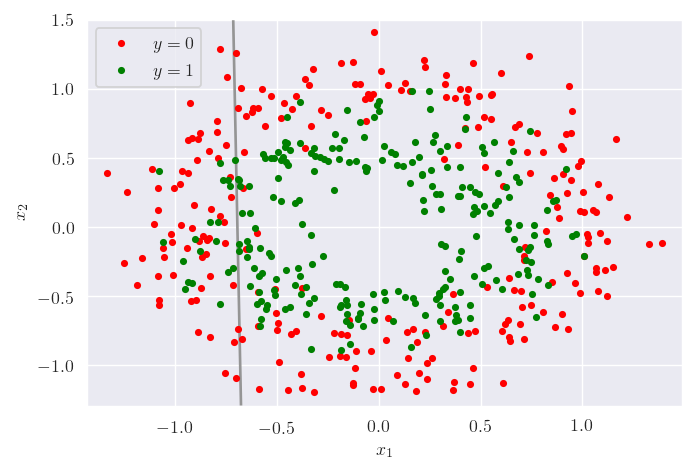

In [12]:
# Function to plot the data points and decision boundary
def plot_results(X, Y, v, trans_func=None):
    # Scatter plot in feature space
    plt.plot(X[Y==0,0], X[Y==0,1], '.', label = "$y=0$", c='r')
    plt.plot(X[Y==1,0], X[Y==1,1], '.', label = "$y=1$", c='g')
    
    # Compute axis limits
    x0_lower = X[:,0].min() - 0.1
    x0_upper = X[:,0].max() + 0.1
    x1_lower = X[:,1].min() - 0.1
    x1_upper = X[:,1].max() + 0.1
    
    # Generate grid over feature space
    x0, x1 = np.mgrid[x0_lower:x0_upper:.01, x1_lower:x1_upper:.01]
    grid = np.c_[x0.ravel(), x1.ravel()]
    if (trans_func is not None):
        grid = trans_func(grid) # apply transformation to features
    arg = (np.dot(grid, v[1::]) + v[0]).reshape(x0.shape)
    
    # Plot decision boundary (where w^T x + b == 0)
    plt.contour(x0, x1, arg, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)
    plt.legend()
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.show()

plot_results(X, Y, v_opt)

**Question:** Is the solution what you expected? Is it a good fit for the data?

**Answer:** *It's not a good fit because logistic regression is a linear classifier, and the data is not linearly seperable.*

**Question:** What's the accuracy of this model? Fill in the code below assuming the following decision function

\begin{equation}
    \hat{y} = \begin{cases}
        1, \mathrm{if} \ p(y = 1|\mathbf{x}) \geq \frac{1}{2}, \\
        0, \mathrm{otherwise}.
    \end{cases}
\end{equation}

In [13]:
from sklearn.metrics import accuracy_score

def get_predictions(v_opt, X_test):
    #  Implement the logistic regression prediction rule here
    """
    Inputs:
    v_opt:        Optimized weights, shape [n+1]
                  Should contain bias term as zeroth element
    X_test:       Testing data, shape [N_test, n]
    
    Outputs:
    Y_test_pred:  Vector of predictions for given test instances
    """
    w = v_opt[1:]
    b = v_opt[0]
    y_prob = sigmoid(np.dot(X_test, w) + b)
    Y_test_pred = np.where(y_prob > 0.5, 1, 0)
    
    return Y_test_pred

Y_test_pred = get_predictions(v_opt, X_test)

print('Accuracy achieved: {:.3f}'.format(accuracy_score(Y_test, Y_test_pred)))

Accuracy achieved: 0.300


Writing nice docstrings allows your code to be self-documenting! :) 

In [14]:
get_predictions?

Signature: get_predictions(v_opt, X_test)
Docstring:
Inputs:
v_opt:        Optimized weights, shape [n+1]
              Should contain bias term as zeroth element
X_test:       Testing data, shape [N_test, n]

Outputs:
Y_test_pred:  Vector of predictions for given test instances
File:      /data/cephfs/punim0011/jtan/github/comp90051-2020-s1/worksheets/<ipython-input-13-ff8b649d1113>
Type:      function


### 4. Adding polynomial features

We've seen that ordinary logistic regression does poorly on this data set, because the data is not linearly separable in the $x_0,x_1$ feature space.

We can get around this problem using basis expansion. In this case, we'll augment the feature space by adding polynomial features of degree 2. In other words, we replace the original feature matrix $\mathbf{X}$ by a transformed feature matrix $\mathbf{\Phi}$ which contains additional columns corresponding to $x_0^2$, $x_0 x_1$ and $x_1^2$. This is done using the function `add_quadratic_features` defined below.

**Note:** There's a built-in function in `sklearn` for adding polynomial features located at `sklearn.preprocessing.PolynomialFeatures`.

In [15]:
# X: original feature matrix
def add_quadratic_features(X):
    return np.column_stack([X, X[:,0]**2, X[:,0]*X[:,1], X[:,1]**2])

def add_cubic_features(X):
    u, v= X[:,0], X[:,1]
    return np.column_stack([X, u**2, u*v, v**2, u**2*v, u*v**2, u**3, v**3])

Phi_train = add_quadratic_features(X_train)
Phi_test = add_quadratic_features(X_test)

Lets check the shape of the augmented feature matrix $\Phi$, is it what you expect?

In [16]:
print(r'Shape of Phi:', Phi_train.shape)

Shape of Phi: (400, 5)


Let's apply our custom logistic regression function again on the augmented feature space.

v: [-0.17994827 -0.10336434  0.00110299 -0.6402658   0.02660937 -0.75258546]  | Objective: 261.681 | Gradient 2-norm: 60.145
v: [ 3.57467935e-01 -1.82570021e-01  4.87849273e-04 -1.14659512e+00
  6.06957193e-02 -1.37314425e+00]  | Objective: 233.254 | Gradient 2-norm: 48.804
v: [ 0.73709048  0.56646487  0.23725455 -1.79745963  0.06064046 -1.6669837 ]  | Objective: 223.341 | Gradient 2-norm: 47.042
v: [ 1.17041419  0.41005366  0.1775082  -2.70117145 -0.06223824 -1.71401927]  | Objective: 208.138 | Gradient 2-norm: 37.797
v: [ 1.84758379  0.27487546  0.27655461 -2.98295403 -0.18745198 -2.8424073 ]  | Objective: 184.025 | Gradient 2-norm: 22.998
v: [ 2.1136862   0.37325408 -0.23687634 -3.20490539  0.20498101 -3.23391758]  | Objective: 180.035 | Gradient 2-norm: 20.637
v: [ 2.40855303  0.25968978 -0.09996675 -3.52140961  0.67227874 -3.57627736]  | Objective: 173.551 | Gradient 2-norm: 14.506
v: [ 3.03707825  0.1561748   0.00504284 -4.19034015 -0.02491359 -4.37611497]  | Objective: 164.105 |

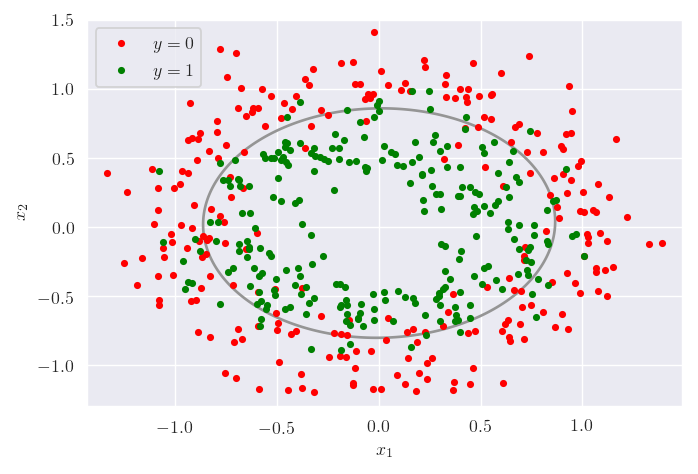

In [17]:
Lambda = 10**(-3)
v_initial = np.zeros(Phi_train.shape[1] + 1) # fill in a vector of zeros of appropriate length
v_opt_phi, v_history, grad_history = logistic_regression_bfgs(Phi_train, Y_train, Lambda, v_initial)
plot_results(X, Y, v_opt_phi, trans_func=add_quadratic_features)
# plot_results(X, Y, v_opt_phi, trans_func=add_cubic_features)

This time we should get a better result for the accuracy on the test set.

In [18]:
from sklearn.metrics import accuracy_score

w_phi = v_opt_phi[1:]
b_phi = v_opt_phi[0]
logits = np.dot(Phi_test, w_phi) + b_phi
Y_test_pred = np.where(logits > 0, 1, 0) # fill in
print('Accuracy achieved: {:.3f}'.format(accuracy_score(Y_test, Y_test_pred)))

Accuracy achieved: 0.910


### 5. Effect of regularisation

So far, we've fixed the regularisation constant so that $\lambda = 1$. (Note it's possible to choose an "optimal" value for $\lambda$ by applying cross-validation.)

**Question:** What do you think will happen if we switch the regularisation off? Try setting $\lambda$ to a small value (say $10^{-3}$) and check whether the accuracy of the model is affected. You may wish to scan across a range of values for $\lambda$ and observe which value gives you the best accuracy on the test set. You may want to experiment with cubic or another monomial features.

**Answer:** *Generally speaking, we risk overfitting if the regularisation constant is too small (or switched off entirely). Whether regularization helps with generalization may depend on the size of your training dataset and the features considered. 

### 6. Logistic regression using sklearn

Now that you have some insight into the optimisation problem behind logistic regression, you should feel confident in using the built-in implementation in `sklearn` (or other packages). (Note `sklearn` uses BFGS for optimization).
Note that the `sklearn` implementation handles floating point underflow/overflow more carefully than we have done, and uses faster numerical optimisation algorithms.

In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1)
clf.fit(Phi_train, Y_train)

/home/jtan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
from sklearn.metrics import accuracy_score
Y_test_pred = clf.predict(Phi_test)
accuracy_score(Y_test, Y_test_pred)

0.91

### Bonus
#### **Exercise 4**
Consider how you would extend logistic regression to the multiclass case where $y \in \{c_1, \ldots c_m\}$. How would you model the conditional probability for class $k$: $p(y=c_k \vert \mathbf{x})$?